# Preliminaries

In [1]:
import pandas as pd

In [2]:
# For regular expressions:
import re

In [3]:
# For web scraping:
import requests
from bs4 import BeautifulSoup

In [4]:
# Scikit-learn package for unsupervised learning:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [5]:
# For further cleaning
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer 

## `nltk` package for textual analysis

In [6]:
# Import and download popular text corpa
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/ahmed/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to

True

In [7]:
# For sentiment analysis:
import nltk.sentiment
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ahmed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# For text cleaning:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
import string

---

# Textual analysis with some Friends

The file [Friends_Transcript.txt](https://raw.githubusercontent.com/ahmedgc/2024_insead_python_workshop/main/Friends_Transcript.txt) contains text data: the script for the pilot episode of the TV series "Friends".

<img src="https://m.media-amazon.com/images/M/MV5BNDVkYjU0MzctMWRmZi00NTkxLTgwZWEtOWVhYjZlYjllYmU4XkEyXkFqcGdeQXVyNTA4NzY1MzY@._V1_FMjpg_UX1000_.jpg" 
alt="Friends" width="50%"/>

## Reading data from the text file

We begin by inspecting the first 10 lines of this text file:

In [9]:
line_number = 1
with open("Friends_Transcript.txt", "r") as f:
    for line in f:
        if line_number <= 10:
            print(line)
        line_number = line_number + 1

THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)

Written by: Marta Kauffman & David Crane

[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]

Monica: There's nothing to tell! He's just some guy I work with!

Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!

Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?

Phoebe: Wait, does he eat chalk?

(They all stare, bemused.)

Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!

Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.



Let's read in all the lines in the file, and gather them in a list of strings:

In [10]:
all_lines = []
with open("Friends_Transcript.txt", "r") as f:
    for line in f:
        all_lines = all_lines + [line]

In [11]:
len(all_lines)

66541

In [12]:
all_lines[0:20]

['THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\n',
 'Written by: Marta Kauffman & David Crane\n',
 '[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\n',
 "Monica: There's nothing to tell! He's just some guy I work with!\n",
 "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\n",
 'Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\n',
 'Phoebe: Wait, does he eat chalk?\n',
 '(They all stare, bemused.)\n',
 "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\n",
 "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\n",
 'Chandler: Sounds like a date to me.\n',
 '[Time Lapse]\n',
 "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\n",
 'All: Oh, yeah. Had that dream.\n',
 "Chandler: Then I look down,

In the show, there are 6 recurring characters (Chandler, Joey, Monica, Phoebe, Rachel, Ross). Let's extract only the lines that pertain to dialog spoken by one of these main characters:

In [13]:
main_dialog_lines = [line for line in all_lines if (
    line.startswith('Chandler:') | line.startswith('Joey:') | line.startswith('Monica:') 
    | line.startswith('Phoebe:') | line.startswith('Rachel:') | line.startswith('Ross:')
)]

In [14]:
len(main_dialog_lines)

46931

In [15]:
main_dialog_lines[0:20]

["Monica: There's nothing to tell! He's just some guy I work with!\n",
 "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\n",
 'Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\n',
 'Phoebe: Wait, does he eat chalk?\n',
 "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\n",
 "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\n",
 'Chandler: Sounds like a date to me.\n',
 "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\n",
 "Chandler: Then I look down, and I realize there's a phone... there.\n",
 'Joey: Instead of...?\n',
 "Chandler: That's right.\n",
 'Joey: Never had that dream.\n',
 'Phoebe: No.\n',
 "Chandler: All of a sudden, the phone starts to ring. Now I don't know what to do, everybody starts looking at me. \n",
 "Monica: An

But we can see that there is still text that is situational, and not part of a dialog: it's the text in between parentheses () and square brackets []. So we need to eliminate it. 

This uses a **regular expression** to detect any text that is in between parenthese () and replace it with an empty string.

In [16]:
main_dialog_lines = [re.sub("\(.*?\)", "", line) for line in main_dialog_lines]
main_dialog_lines[0:20]

["Monica: There's nothing to tell! He's just some guy I work with!\n",
 "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\n",
 'Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\n',
 'Phoebe: Wait, does he eat chalk?\n',
 "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\n",
 "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\n",
 'Chandler: Sounds like a date to me.\n',
 "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\n",
 "Chandler: Then I look down, and I realize there's a phone... there.\n",
 'Joey: Instead of...?\n',
 "Chandler: That's right.\n",
 'Joey: Never had that dream.\n',
 'Phoebe: No.\n',
 "Chandler: All of a sudden, the phone starts to ring. Now I don't know what to do, everybody starts looking at me. \n",
 "Monica: An

This uses another regular expression to detect any text that is in between square brackets [] and replace it with an empty string.

In [17]:
main_dialog_lines = [re.sub("\[.*?\]", "", line) for line in main_dialog_lines]
main_dialog_lines[0:20]

["Monica: There's nothing to tell! He's just some guy I work with!\n",
 "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\n",
 'Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\n',
 'Phoebe: Wait, does he eat chalk?\n',
 "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\n",
 "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\n",
 'Chandler: Sounds like a date to me.\n',
 "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\n",
 "Chandler: Then I look down, and I realize there's a phone... there.\n",
 'Joey: Instead of...?\n',
 "Chandler: That's right.\n",
 'Joey: Never had that dream.\n',
 'Phoebe: No.\n',
 "Chandler: All of a sudden, the phone starts to ring. Now I don't know what to do, everybody starts looking at me. \n",
 "Monica: An

Let's separate out the subject doing the talking from what they say. This will help us identify speech later.

So instead of a list of strings, where each string is a line, we want a list of *tuples*, split into the person talking and the words being said.

Here are some examples of what we intend:

In [18]:
'Chandler: Happy birthday, pal! \n'

'Chandler: Happy birthday, pal! \n'

In [19]:
'Chandler: Happy birthday, pal! \n'.split(':', maxsplit=1)

['Chandler', ' Happy birthday, pal! \n']

In [20]:
tuple('Chandler: Happy birthday, pal! \n'.split(':', maxsplit=1))

('Chandler', ' Happy birthday, pal! \n')

In [21]:
main_dialog_tupes = [tuple(line.split(':', maxsplit=1)) for line in main_dialog_lines]
main_dialog_tupes[0:20]

[('Monica', " There's nothing to tell! He's just some guy I work with!\n"),
 ('Joey',
  " C'mon, you're going out with the guy! There's gotta be something wrong with him!\n"),
 ('Chandler',
  ' All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\n'),
 ('Phoebe', ' Wait, does he eat chalk?\n'),
 ('Phoebe',
  " Just, 'cause, I don't want her to go through what I went through with Carl- oh!\n"),
 ('Monica',
  " Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\n"),
 ('Chandler', ' Sounds like a date to me.\n'),
 ('Chandler',
  " Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\n"),
 ('Chandler', " Then I look down, and I realize there's a phone... there.\n"),
 ('Joey', ' Instead of...?\n'),
 ('Chandler', " That's right.\n"),
 ('Joey', ' Never had that dream.\n'),
 ('Phoebe', ' No.\n'),
 ('Chandler',
  " All of a sudden, the phone starts to rin

In [22]:
# Eliminate leading whitespace in the second element of each tupe
main_dialog_tupes = [(subject, speech.strip()) for (subject, speech) in main_dialog_tupes]
main_dialog_tupes

[('Monica', "There's nothing to tell! He's just some guy I work with!"),
 ('Joey',
  "C'mon, you're going out with the guy! There's gotta be something wrong with him!"),
 ('Chandler',
  'All right Joey, be nice. So does he have a hump? A hump and a hairpiece?'),
 ('Phoebe', 'Wait, does he eat chalk?'),
 ('Phoebe',
  "Just, 'cause, I don't want her to go through what I went through with Carl- oh!"),
 ('Monica',
  "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex."),
 ('Chandler', 'Sounds like a date to me.'),
 ('Chandler',
  "Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked."),
 ('Chandler', "Then I look down, and I realize there's a phone... there."),
 ('Joey', 'Instead of...?'),
 ('Chandler', "That's right."),
 ('Joey', 'Never had that dream.'),
 ('Phoebe', 'No.'),
 ('Chandler',
  "All of a sudden, the phone starts to ring. Now I don't know what to do, everybod

## Quiz: "crazy"

Using the data above (`main_dialog_lines` or `main_dialog_tupes`), count how many times each of the main characters says the word "crazy" (or "Crazy").

*Hint*: you may want to use the function `.count()`


### My solution

In [ ]:
main_dialog_tupes[:10]

In [23]:
all_counts = [(subject, line.lower().count('crazy')) for (subject, line) in main_dialog_tupes]
all_counts

[('Monica', 0),
 ('Joey', 0),
 ('Chandler', 0),
 ('Phoebe', 0),
 ('Phoebe', 0),
 ('Monica', 0),
 ('Chandler', 0),
 ('Chandler', 0),
 ('Chandler', 0),
 ('Joey', 0),
 ('Chandler', 0),
 ('Joey', 0),
 ('Phoebe', 0),
 ('Chandler', 0),
 ('Monica', 0),
 ('Chandler', 0),
 ('Ross', 0),
 ('Joey', 0),
 ('Monica', 0),
 ('Ross', 0),
 ('Chandler', 0),
 ('Monica', 0),
 ('Joey', 0),
 ('Monica', 0),
 ('Ross', 0),
 ('Phoebe', 0),
 ('Ross', 0),
 ('Phoebe', 0),
 ('Ross', 0),
 ('Monica', 0),
 ('Ross', 0),
 ('Joey', 0),
 ('Ross', 0),
 ('Chandler', 0),
 ('Ross', 0),
 ('Monica', 0),
 ('Ross', 0),
 ('Joey', 0),
 ('Joey', 0),
 ('Ross', 0),
 ('Chandler', 0),
 ('Monica', 0),
 ('Rachel', 0),
 ('Monica', 0),
 ('Rachel', 0),
 ('Ross', 0),
 ('Monica', 0),
 ('Rachel', 0),
 ('Monica', 0),
 ('Rachel', 0),
 ('Monica', 0),
 ('Chandler', 0),
 ('Ross', 0),
 ('Rachel', 0),
 ('Phoebe', 0),
 ('Chandler', 0),
 ('Joey', 0),
 ('Rachel', 0),
 ('Ross', 0),
 ('Rachel', 0),
 ('Monica', 0),
 ('Rachel', 0),
 ('Monica', 0),
 ('Phoebe', 

In [25]:
def extract_count(subject_name):
    subject_counts = [count for (subject, count) in all_counts if subject == subject_name]
    return sum(subject_counts)

In [26]:
extract_count('Chandler')

40

In [27]:
extract_count('Joey')

34

In [28]:
extract_count('Monica')

42

In [29]:
extract_count('Phoebe')

34

In [30]:
extract_count('Rachel')

33

In [31]:
extract_count('Ross')

33

In [32]:
print('Chandler says it ' + str(extract_count('Chandler')) + ' times')
print('Joey says it '     + str(extract_count('Joey'))     + ' times')
print('Monica says it '   + str(extract_count('Monica'))   + ' times')
print('Phoebe says it '   + str(extract_count('Phoebe'))   + ' times')
print('Rachel says it '   + str(extract_count('Rachel'))   + ' times')
print('Ross says it '     + str(extract_count('Ross'))     + ' times')

Chandler says it 40 times
Joey says it 34 times
Monica says it 42 times
Phoebe says it 34 times
Rachel says it 33 times
Ross says it 33 times


## Using Pandas Data Frames with text

Pandas dataframes are always useful, so let's convert from a list of tupes to a dataframe of columns:

In [33]:
main_dialog_df = pd.DataFrame(main_dialog_tupes, columns =['Subject', 'Speech'])
main_dialog_df

,Subject,Speech
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
...,...,...
46926,Chandler,"Oh, it's gonna be okay."
46927,Rachel,Do you guys have to go to the new house right ...
46928,Monica,We got some time.
46929,Rachel,"Okay, should we get some coffee?"


In [34]:
main_dialog_df['Speech']

0        There's nothing to tell! He's just some guy I ...
1        C'mon, you're going out with the guy! There's ...
2        All right Joey, be nice. So does he have a hum...
3                                 Wait, does he eat chalk?
4        Just, 'cause, I don't want her to go through w...
                               ...                        
46926                              Oh, it's gonna be okay.
46927    Do you guys have to go to the new house right ...
46928                                    We got some time.
46929                     Okay, should we get some coffee?
46930                                         Sure. Where?
Name: Speech, Length: 46931, dtype: object

In [35]:
main_dialog_df['Speech'].str.lower()

0        there's nothing to tell! he's just some guy i ...
1        c'mon, you're going out with the guy! there's ...
2        all right joey, be nice. so does he have a hum...
3                                 wait, does he eat chalk?
4        just, 'cause, i don't want her to go through w...
                               ...                        
46926                              oh, it's gonna be okay.
46927    do you guys have to go to the new house right ...
46928                                    we got some time.
46929                     okay, should we get some coffee?
46930                                         sure. where?
Name: Speech, Length: 46931, dtype: object

In [36]:
main_dialog_df['Speech'].str.lower().str.count('crazy')

0        0
1        0
2        0
3        0
4        0
        ..
46926    0
46927    0
46928    0
46929    0
46930    0
Name: Speech, Length: 46931, dtype: int64

In [37]:
main_dialog_df['crazy_counts'] = main_dialog_df['Speech'].str.lower().str.count('crazy')

In [38]:
main_dialog_df.groupby('Subject')['crazy_counts'].sum()

Subject
Chandler    40
Joey        34
Monica      42
Phoebe      34
Rachel      33
Ross        33
Name: crazy_counts, dtype: int64

**Quiz** Why does the next cell give a different answer?

In [39]:
main_dialog_df['crazy_mentioned'] = main_dialog_df['Speech'].str.lower().str.contains('crazy')
main_dialog_df.groupby('Subject')['crazy_mentioned'].sum()

Subject
Chandler    37
Joey        32
Monica      42
Phoebe      31
Rachel      32
Ross        32
Name: crazy_mentioned, dtype: int64

## Sentiment analysis using VADER

VADER is one methodology developed in an [academic paper](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) to measure the sentiment of text. There's an implementation of this tool in the `nltk` Python package, which we will use now.

In [40]:
# Initialize an object that will perform sentiment analysis for us
analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [41]:
analyzer.polarity_scores('I hate Mondays')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [42]:
analyzer.polarity_scores('I love Fridays')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [43]:
analyzer.polarity_scores('Learning Python is interesting')

{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.4019}

In [44]:
analyzer.polarity_scores('Learning Python is interesting')['compound']

0.4019

In [45]:
main_dialog_df['Speech'].values

array(["There's nothing to tell! He's just some guy I work with!",
       "C'mon, you're going out with the guy! There's gotta be something wrong with him!",
       'All right Joey, be nice. So does he have a hump? A hump and a hairpiece?',
       ..., 'We got some time.', 'Okay, should we get some coffee?',
       'Sure. Where?'], dtype=object)

In [46]:
main_dialog_df['vader_sentiment'] = [analyzer.polarity_scores(speech)['compound'] for speech in main_dialog_df['Speech'].values] 
main_dialog_df

,Subject,Speech,crazy_counts,crazy_mentioned,vader_sentiment
0,Monica,There's nothing to tell! He's just some guy I ...,0,False,0.0000
1,Joey,"C'mon, you're going out with the guy! There's ...",0,False,-0.5696
2,Chandler,"All right Joey, be nice. So does he have a hum...",0,False,0.4871
3,Phoebe,"Wait, does he eat chalk?",0,False,0.0000
4,Phoebe,"Just, 'cause, I don't want her to go through w...",0,False,-0.1316
...,...,...,...,...,...
46926,Chandler,"Oh, it's gonna be okay.",0,False,0.2263
46927,Rachel,Do you guys have to go to the new house right ...,0,False,0.0000
46928,Monica,We got some time.,0,False,0.0000
46929,Rachel,"Okay, should we get some coffee?",0,False,0.2263


In [47]:
main_dialog_df.groupby('Subject')['vader_sentiment'].mean().sort_values(ascending=False)

Subject
Rachel      0.143638
Phoebe      0.141402
Ross        0.128840
Joey        0.123328
Chandler    0.119273
Monica      0.115165
Name: vader_sentiment, dtype: float64

array([[<Axes: title={'center': 'Chandler'}>,
        <Axes: title={'center': 'Joey'}>],
       [<Axes: title={'center': 'Monica'}>,
        <Axes: title={'center': 'Phoebe'}>],
       [<Axes: title={'center': 'Rachel'}>,
        <Axes: title={'center': 'Ross'}>]], dtype=object)

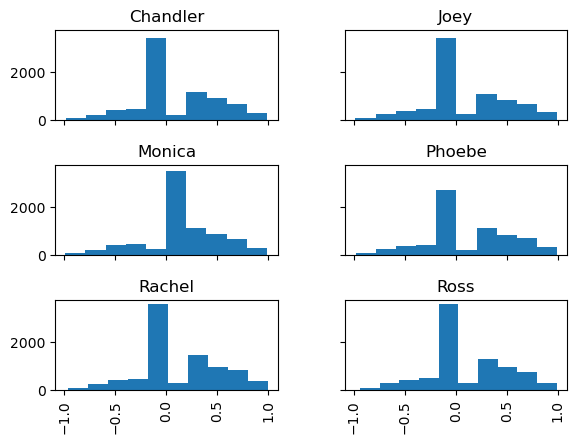

In [48]:
main_dialog_df.hist(column='vader_sentiment', by='Subject', sharex=True, sharey=True)

## Length

Let's count how many words are used in each sentence:

In [49]:
main_dialog_df['Speech'].str.split()

0        [There's, nothing, to, tell!, He's, just, some...
1        [C'mon,, you're, going, out, with, the, guy!, ...
2        [All, right, Joey,, be, nice., So, does, he, h...
3                           [Wait,, does, he, eat, chalk?]
4        [Just,, 'cause,, I, don't, want, her, to, go, ...
                               ...                        
46926                        [Oh,, it's, gonna, be, okay.]
46927    [Do, you, guys, have, to, go, to, the, new, ho...
46928                               [We, got, some, time.]
46929              [Okay,, should, we, get, some, coffee?]
46930                                      [Sure., Where?]
Name: Speech, Length: 46931, dtype: object

In [50]:
main_dialog_df['word_count'] = [len(words) for words in main_dialog_df['Speech'].str.split()]
main_dialog_df

,Subject,Speech,crazy_counts,crazy_mentioned,vader_sentiment,word_count
0,Monica,There's nothing to tell! He's just some guy I ...,0,False,0.0000,11
1,Joey,"C'mon, you're going out with the guy! There's ...",0,False,-0.5696,14
2,Chandler,"All right Joey, be nice. So does he have a hum...",0,False,0.4871,16
3,Phoebe,"Wait, does he eat chalk?",0,False,0.0000,5
4,Phoebe,"Just, 'cause, I don't want her to go through w...",0,False,-0.1316,16
...,...,...,...,...,...,...
46926,Chandler,"Oh, it's gonna be okay.",0,False,0.2263,5
46927,Rachel,Do you guys have to go to the new house right ...,0,False,0.0000,18
46928,Monica,We got some time.,0,False,0.0000,4
46929,Rachel,"Okay, should we get some coffee?",0,False,0.2263,6


In [51]:
main_dialog_df.groupby('Subject')['word_count'].mean().sort_values(ascending=False)

Subject
Phoebe      10.621661
Joey        10.522829
Rachel      10.443318
Ross        10.410346
Chandler    10.160031
Monica       9.812013
Name: word_count, dtype: float64

In [52]:
main_dialog_df.groupby('Subject')['word_count'].max().sort_values(ascending=False)

Subject
Monica      196
Rachel      173
Ross        160
Phoebe      146
Joey        125
Chandler    111
Name: word_count, dtype: int64

array([[<Axes: title={'center': 'Chandler'}>,
        <Axes: title={'center': 'Joey'}>],
       [<Axes: title={'center': 'Monica'}>,
        <Axes: title={'center': 'Phoebe'}>],
       [<Axes: title={'center': 'Rachel'}>,
        <Axes: title={'center': 'Ross'}>]], dtype=object)

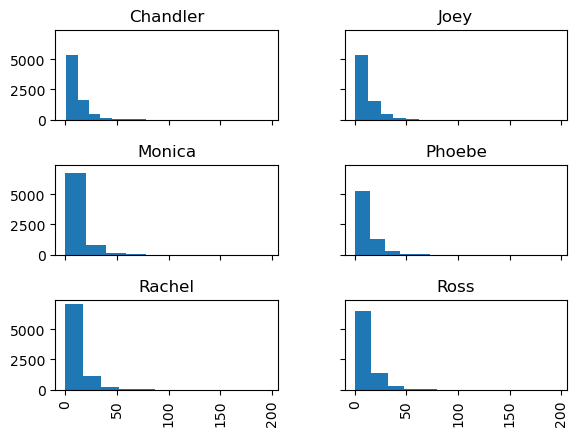

In [53]:
main_dialog_df.hist(column='word_count', by='Subject', sharex=True, sharey=True)

Which characters get the most airtime in total?

In [54]:
main_dialog_df.groupby('Subject')['Speech'].count().sort_values(ascending=False)

Subject
Rachel      8583
Ross        8332
Chandler    7761
Monica      7708
Joey        7622
Phoebe      6925
Name: Speech, dtype: int64

In [55]:
main_dialog_df.groupby('Subject')['word_count'].sum().sort_values(ascending=False)

Subject
Rachel      89635
Ross        86739
Joey        80205
Chandler    78852
Monica      75631
Phoebe      73555
Name: word_count, dtype: int64

---

# Unsupervised learning at the United Nations General Assembly

## Loading and very basic cleaning

In [56]:
united_nations_df = pd.read_csv('un-general-debates-blueprint.csv')

In [57]:
united_nations_df.shape

(7507, 7)

In [58]:
united_nations_df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [59]:
united_nations_df.loc[0,'text']

"33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles wh

In [60]:
united_nations_df.tail()

,session,year,country,country_name,speaker,position,text
7502,70,2015,YEM,Yemen,Mr. Abdrabuh Mansour Hadi Mansour,President,On behalf of the people and the Government of ...
7503,70,2015,YUG,Yugoslavia,Mr. Tomislav Nikolić,President,\nSeventy years have passed since the establis...
7504,70,2015,ZAF,South Africa,Jacob Zuma,President,I should like to congratulate the President an...
7505,70,2015,ZMB,Zambia,Mr. Edgar Chagwa Lungu,President,I would like to begin by thanking the Secretar...
7506,70,2015,ZWE,Zimbabwe,Robert Mugabe,President,Allow me at the outset to extend to Mr. Mogens...


In [61]:
# Remove all numbers using a regular expression
united_nations_df['text'] = united_nations_df['text'].str.replace('\d', '', regex=True)

In [62]:
united_nations_df.loc[0,'text']

": May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles which 

In [63]:
# As part of the processing, it's common to exclude common words that are uninformative ("stop words").
# We'll use a predefined set in the nltk package. 
# We'll pass this to the next step.
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## NMF on word counts

We'll use the `scikit-learn` [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object to split each speech into words (tokens), remove stop-words, set words to lowercase, and extract the count of each word that appears:

In [64]:
count_text_vectorizer = CountVectorizer(stop_words=stop_words)
count_text_vectors = count_text_vectorizer.fit_transform(united_nations_df['text'])
count_text_vectors.shape

(7507, 51509)

In [65]:
print(count_text_vectors[0,:])

  (0, 28191)	5
  (0, 17234)	4
  (0, 9785)	1
  (0, 35316)	1
  (0, 9276)	1
  (0, 1399)	9
  (0, 11524)	3
  (0, 14468)	1
  (0, 35315)	1
  (0, 47202)	4
  (0, 17061)	4
  (0, 41061)	5
  (0, 18723)	6
  (0, 3080)	7
  (0, 44903)	1
  (0, 50704)	1
  (0, 1068)	2
  (0, 20557)	2
  (0, 15758)	2
  (0, 2139)	3
  (0, 8587)	1
  (0, 17660)	9
  (0, 7443)	8
  (0, 48200)	44
  (0, 30457)	18
  :	:
  (0, 12457)	1
  (0, 9796)	1
  (0, 6056)	1
  (0, 12226)	1
  (0, 50090)	1
  (0, 35255)	1
  (0, 38692)	1
  (0, 2332)	1
  (0, 10955)	1
  (0, 36738)	1
  (0, 33245)	1
  (0, 25301)	2
  (0, 43582)	1
  (0, 41216)	2
  (0, 43254)	1
  (0, 5926)	1
  (0, 48497)	1
  (0, 17071)	1
  (0, 49509)	1
  (0, 17229)	1
  (0, 19759)	1
  (0, 27982)	1
  (0, 29348)	1
  (0, 18797)	1
  (0, 45483)	1


In [66]:
count_text_vectorizer.get_feature_names_out()[0:50]

array(['__', '_and', '_order', '_to', 'aaaembty', 'aachen', 'aadd', 'aaf',
       'aafsap', 'aaiun', 'aan', 'aapirit', 'aarce', 'aartsen', 'aay',
       'ab', 'aba', 'ababa', 'abacc', 'abacha', 'aback', 'abaco',
       'abadan', 'abadi', 'abai', 'aban', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abandons', 'abapo', 'abaroa',
       'abarundi', 'abasa', 'abasement', 'abashed', 'abashi', 'abass',
       'abatable', 'abate', 'abated', 'abatement', 'abates', 'abating',
       'abba', 'abbas', 'abbe', 'abbo', 'abbot'], dtype=object)

In [67]:
# Fit an NMF model with 5 topics to vectors of word counts
nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(count_text_vectors)
H_text_matrix = nmf_text_model.components_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [68]:
# Here's a function to display the most important words in each topic:
def display_topics(model, features, no_top_words=10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
            word_vector[largest[i]]*100.0/total))

In [69]:
# Interpreting topics from the fitted model based on the most important words in each:
display_topics(nmf_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 countries (2.30)
 international (1.26)
 world (1.25)
 economic (1.22)
 development (0.93)
 developing (0.89)
 must (0.64)
 new (0.54)
 africa (0.49)
 south (0.46)

Topic 01
 nations (3.34)
 united (3.11)
 world (1.05)
 must (0.93)
 human (0.72)
 development (0.67)
 states (0.61)
 new (0.59)
 us (0.56)
 general (0.52)

Topic 02
 states (2.22)
 united (1.80)
 international (1.13)
 nuclear (1.12)
 nations (1.01)
 peace (0.88)
 countries (0.87)
 world (0.80)
 soviet (0.74)
 security (0.72)

Topic 03
 international (2.61)
 security (1.36)
 peace (1.34)
 community (0.89)
 development (0.75)
 efforts (0.72)
 council (0.70)
 general (0.67)
 also (0.62)
 country (0.56)

Topic 04
 people (2.09)
 world (0.89)
 africa (0.84)
 peace (0.77)
 government (0.70)
 country (0.70)
 peoples (0.69)
 south (0.69)
 countries (0.60)
 independence (0.47)


The above topics don't look very distinct to my eyes, so this didn't do a great job. We can:
* Improve our processing
* Try a different number of topics
* Try a different machine learning model


Let's work on our processing. Instead of using every speech, let's use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object to do some extra processing steps:
* Ignore very rare words that appear less than 5 times in all speeches: these introduce noise.
* Ignore very common words that appear in more than 70% of all speeches: these also introduce noise.

In [70]:
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(united_nations_df['text'])
count_text_vectors.shape


(7507, 23751)

In [71]:
# Fit an NMF model with 5 topics to vectors of word counts
nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(count_text_vectors)
H_text_matrix = nmf_text_model.components_

In [72]:
# Display topics from the fitted model:
display_topics(nmf_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 co (0.77)
 operation (0.67)
 relations (0.42)
 problem (0.34)
 solution (0.33)
 charter (0.27)
 possible (0.26)
 present (0.26)
 america (0.25)
 mankind (0.24)

Topic 01
 cooperation (0.47)
 challenges (0.29)
 change (0.28)
 regional (0.28)
 reform (0.27)
 terrorism (0.27)
 poverty (0.26)
 sustainable (0.25)
 small (0.24)
 climate (0.24)

Topic 02
 africa (2.77)
 south (1.87)
 african (1.41)
 namibia (0.64)
 independence (0.60)
 delegation (0.57)
 apartheid (0.53)
 regime (0.51)
 struggle (0.44)
 southern (0.44)

Topic 03
 israel (1.54)
 arab (1.44)
 palestinian (0.87)
 israeli (0.62)
 resolutions (0.59)
 aggression (0.58)
 iraq (0.58)
 lebanon (0.57)
 middle (0.52)
 palestine (0.46)

Topic 04
 nuclear (2.11)
 soviet (1.27)
 weapons (1.18)
 republic (1.15)
 union (0.94)
 military (0.78)
 disarmament (0.75)
 relations (0.69)
 arms (0.68)
 democratic (0.59)


The above topics look more interpretable to me.


## NMF on TF-IDF scores

Let's try out another form of pre-processing. Instead of simple word counts, which are also called term frequencies $TF$, let's use TF-IDF scores.

A Term Frequency-Inverse Document Frequency (TF-IDF) score is another way (besides word count) of measuring the importance of a term $t$ in a document $d$:
$$ \text{TF-IDF}(t,d) = \text{TF}(t,d) * \text{IDF}(t) $$

The `scikit-learn` [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) object computes the IDF as follows:

`idf(t) = log [ n / df(t) ] + 1`, where `n` is the total number of documents.

As you can see, this score normalizes the term frequency by how common or rare it is across all documents. The IDF is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient).


In [73]:
# Create vectors of TF-IDF scores
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(united_nations_df['text'])
tfidf_text_vectors.shape

(7507, 23751)

In [74]:
print(tfidf_text_vectors[0,:])

  (0, 21228)	0.00691654949020387
  (0, 9108)	0.004454711295553653
  (0, 13668)	0.007167915211758051
  (0, 9469)	0.00586310625892408
  (0, 8382)	0.004667921976850826
  (0, 22999)	0.007554535780234439
  (0, 8301)	0.004480121459172623
  (0, 22541)	0.00888665915530505
  (0, 2714)	0.0077032545278925115
  (0, 20097)	0.004623726287053599
  (0, 19210)	0.008840931187626515
  (0, 20279)	0.007769734697599966
  (0, 12001)	0.014317885236215334
  (0, 15293)	0.005338933237001794
  (0, 16989)	0.0068432149064961735
  (0, 5109)	0.013734766873371797
  (0, 1087)	0.007152981750695669
  (0, 18091)	0.0050689178808699656
  (0, 16250)	0.005162991849691455
  (0, 23246)	0.012979048864536586
  (0, 5799)	0.006032392641211712
  (0, 2768)	0.0038412068153092006
  (0, 4576)	0.009700195012610355
  (0, 5908)	0.009424667653192834
  (0, 1590)	0.007642519510458102
  :	:
  (0, 20963)	0.02709378823996839
  (0, 301)	0.023838609824956534
  (0, 18767)	0.007020279743231565
  (0, 16027)	0.003502963641787159
  (0, 15683)	0.0073854

### With 5 topics

In [75]:
# Fit an NMF model with 5 topics to vectors of TF-IDF scores
nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [76]:
# Display topics from the fitted model:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 nuclear (0.64)
 co (0.56)
 operation (0.48)
 soviet (0.43)
 disarmament (0.42)
 weapons (0.34)
 relations (0.34)
 europe (0.33)
 republic (0.31)
 detente (0.27)

Topic 01
 cooperation (0.28)
 sustainable (0.26)
 challenges (0.25)
 terrorism (0.25)
 reform (0.24)
 climate (0.23)
 change (0.21)
 millennium (0.20)
 poverty (0.18)
 goals (0.18)

Topic 02
 africa (0.92)
 african (0.63)
 south (0.57)
 namibia (0.34)
 delegation (0.33)
 apartheid (0.26)
 independence (0.25)
 angola (0.23)
 regime (0.22)
 oau (0.21)

Topic 03
 arab (0.94)
 israel (0.80)
 palestinian (0.56)
 lebanon (0.50)
 israeli (0.50)
 iraq (0.44)
 resolutions (0.38)
 occupation (0.30)
 aggression (0.30)
 palestine (0.30)

Topic 04
 american (0.23)
 america (0.23)
 latin (0.23)
 democracy (0.14)
 central (0.13)
 panama (0.13)
 justice (0.13)
 bolivia (0.13)
 freedom (0.12)
 guatemala (0.12)


### Understanding the NMF model

Here's a conceptual illustration of how this works. We began by creating a Document-Term Matrix (DTM), which counts how many times certain words appear in each document. Under the hood, this is a matrix. And matrices can be factorized into products of other matrices, under certain conditions.

NMF stands for Non-Negative Matrix Factorization. The unsupervised machine learning model we used above performs NMF on the DTM to extract a list of topics:

<img src="https://miro.medium.com/v2/resize:fit:1400/1*Cdk8UXkHqkLxfPEFTNEU4A.jpeg" width="75%" />




There are other ways to estimate the topics in text, with their own strengths & weaknesses. The NMF model:
* is relatively simple
* is very fast
* can perform well: an NMF algorithm won the famous [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize)



Having said that, probabilistic methods seem to be favored nowadays, especially Latent Dirichlet Allocation (LDA). However, these are too slow to demonstrate in the workshop, so you'll do this as an exercise yourself (later). I will shortly show you another model (SVD), but for now let's explore the NMF results further...


### Using the weights/loadings

In [77]:
W_text_matrix.shape

(7507, 5)

In [78]:
weights_df = pd.DataFrame(W_text_matrix)
weights_df.columns = [('weight_on_topic_' + str(c)) for c in weights_df.columns.values]
weights_df

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
0,0.078260,0.000000,0.001863,0.048542,0.005639
1,0.042271,0.004365,0.002896,0.012044,0.104846
2,0.045642,0.022755,0.014467,0.001702,0.063432
3,0.047121,0.015419,0.011294,0.010841,0.038488
4,0.064772,0.019471,0.000000,0.000010,0.078961
...,...,...,...,...,...
7502,0.000000,0.028512,0.000000,0.051583,0.005799
7503,0.003088,0.038186,0.000000,0.012501,0.050119
7504,0.000000,0.073762,0.077998,0.000000,0.000000
7505,0.000000,0.087166,0.028370,0.000000,0.000887


In [79]:
united_nations_df.shape

(7507, 7)

In [80]:
united_nations_df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,: May I first convey to our President the cong...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,.\t : It is a fortunate coincidence that preci...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,".\t It is a pleasure for me to extend to you,..."
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,.\t May I begin by expressing to Ambassador H...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,". No doubt each of us, before coming up to thi..."


In [81]:
# Concatenating DataFrames side-by-side/horizontally can be dangeous, but we know that they refer to the same subjects...
year_country_weights_df = pd.concat([
      united_nations_df[['year', 'country_name']]
    , weights_df
], axis=1)

In [82]:
year_country_weights_df.shape

(7507, 7)

In [83]:
year_country_weights_df.head(10)

,year,country_name,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
0,1970,Albania,0.078260,0.000000,0.001863,0.048542,0.005639
1,1970,Argentina,0.042271,0.004365,0.002896,0.012044,0.104846
2,1970,Australia,0.045642,0.022755,0.014467,0.001702,0.063432
3,1970,Austria,0.047121,0.015419,0.011294,0.010841,0.038488
4,1970,Belgium,0.064772,0.019471,0.000000,0.000010,0.078961
5,1970,Belarus,0.103048,0.000000,0.015757,0.027449,0.000000
6,1970,"Bolivia, Plurinational State of",0.025389,0.000000,0.003206,0.011075,0.146196
7,1970,Brazil,0.036491,0.000445,0.005400,0.004491,0.102762
8,1970,Canada,0.021756,0.021502,0.015737,0.006942,0.043203
9,1970,Cameroon,0.027982,0.006877,0.027334,0.008291,0.081954


In [84]:
# For each year + country, there is 1 speech only
year_country_weights_df.groupby(['year', 'country_name']).value_counts().max()

1

In [85]:
# Summarize at a country level
year_country_weights_df.groupby('country_name').mean()

,year,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,,
Afghanistan,1993.000000,0.039023,0.027543,0.015458,0.036592,0.010640
Albania,1992.500000,0.044788,0.030616,0.005143,0.017729,0.012171
Algeria,1992.500000,0.015846,0.030974,0.051325,0.037526,0.031459
Andorra,2004.500000,0.000182,0.035484,0.000164,0.005068,0.056900
Angola,1996.447368,0.009641,0.035323,0.088238,0.011551,0.008215
...,...,...,...,...,...,...
Viet Nam,1996.500000,0.059033,0.037622,0.009796,0.005373,0.006038
Yemen,1993.000000,0.015530,0.021951,0.020917,0.105792,0.006797
Yugoslavia,1991.648649,0.052714,0.020693,0.021316,0.014991,0.023533


In [86]:
# Re-running this line from above to remind us what the fitted model topics are:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 nuclear (0.64)
 co (0.56)
 operation (0.48)
 soviet (0.43)
 disarmament (0.42)
 weapons (0.34)
 relations (0.34)
 europe (0.33)
 republic (0.31)
 detente (0.27)

Topic 01
 cooperation (0.28)
 sustainable (0.26)
 challenges (0.25)
 terrorism (0.25)
 reform (0.24)
 climate (0.23)
 change (0.21)
 millennium (0.20)
 poverty (0.18)
 goals (0.18)

Topic 02
 africa (0.92)
 african (0.63)
 south (0.57)
 namibia (0.34)
 delegation (0.33)
 apartheid (0.26)
 independence (0.25)
 angola (0.23)
 regime (0.22)
 oau (0.21)

Topic 03
 arab (0.94)
 israel (0.80)
 palestinian (0.56)
 lebanon (0.50)
 israeli (0.50)
 iraq (0.44)
 resolutions (0.38)
 occupation (0.30)
 aggression (0.30)
 palestine (0.30)

Topic 04
 american (0.23)
 america (0.23)
 latin (0.23)
 democracy (0.14)
 central (0.13)
 panama (0.13)
 justice (0.13)
 bolivia (0.13)
 freedom (0.12)
 guatemala (0.12)


In [87]:
year_country_weights_df.drop(columns='year').groupby('country_name').mean().sort_values('weight_on_topic_0', ascending=False)

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,
German Dem. Republic,0.124240,0.002531,0.002565,0.001563,0.000901
Czechoslovakia,0.122587,0.006087,0.001145,0.005233,0.011662
Russian Federation,0.082753,0.036605,0.000000,0.011731,0.017147
Ukraine,0.076607,0.032157,0.002423,0.005360,0.003528
Bulgaria,0.074792,0.037165,0.000962,0.008067,0.005097
...,...,...,...,...,...
Tonga,0.000846,0.081354,0.000556,0.000539,0.002000
"Palestine, State of",0.000431,0.015338,0.002788,0.134647,0.008389
Andorra,0.000182,0.035484,0.000164,0.005068,0.056900


In [88]:
year_country_weights_df.drop(columns='year').groupby('country_name').mean().sort_values('weight_on_topic_1', ascending=False)

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,
Kiribati,0.000000,0.095676,0.000150,0.000296,0.005826
Nauru,0.002308,0.085183,0.000404,0.000182,0.004748
Montenegro,0.005694,0.085049,0.000000,0.000870,0.000268
"Micronesia, Federated States of",0.005021,0.084761,0.000657,0.000625,0.017860
Tonga,0.000846,0.081354,0.000556,0.000539,0.002000
...,...,...,...,...,...
Israel,0.009017,0.008774,0.000300,0.103091,0.026169
"Bolivia, Plurinational State of",0.006626,0.008167,0.002502,0.002409,0.108338
Czechoslovakia,0.122587,0.006087,0.001145,0.005233,0.011662


In [89]:
year_country_weights_df.drop(columns='year').groupby('country_name').mean().sort_values('weight_on_topic_2', ascending=False)

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,
Zambia,0.010979,0.038884,0.099704,0.004395,0.001864
"Tanzania, United Republic of",0.012298,0.039549,0.091513,0.006473,0.011695
Guinea,0.012549,0.039876,0.089855,0.009620,0.010453
Angola,0.009641,0.035323,0.088238,0.011551,0.008215
Nigeria,0.010783,0.044472,0.086794,0.003301,0.008104
...,...,...,...,...,...
Turkmenistan,0.017879,0.045322,0.000000,0.003585,0.009598
Russian Federation,0.082753,0.036605,0.000000,0.011731,0.017147
Palau,0.002214,0.062976,0.000000,0.001627,0.007813


In [90]:
year_country_weights_df.drop(columns='year').groupby('country_name').mean().sort_values('weight_on_topic_3', ascending=False)

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,
"Palestine, State of",0.000431,0.015338,0.002788,0.134647,0.008389
Syrian Arab Republic,0.013256,0.014668,0.010300,0.134165,0.004964
Lebanon,0.002827,0.008990,0.002121,0.126602,0.015211
Jordan,0.010046,0.020674,0.007386,0.119943,0.010685
Saudi Arabia,0.014010,0.017676,0.010042,0.117356,0.011894
...,...,...,...,...,...
Papua New Guinea,0.014912,0.064120,0.030222,0.000382,0.003843
Kiribati,0.000000,0.095676,0.000150,0.000296,0.005826
Marshall Islands,0.007361,0.076959,0.000307,0.000283,0.008559


In [91]:
year_country_weights_df.drop(columns='year').groupby('country_name').mean().sort_values('weight_on_topic_4', ascending=False)

,weight_on_topic_0,weight_on_topic_1,weight_on_topic_2,weight_on_topic_3,weight_on_topic_4
country_name,,,,,
"Bolivia, Plurinational State of",0.006626,0.008167,0.002502,0.002409,0.108338
"Venezuela, Bolivarian Republic of",0.009963,0.010333,0.005897,0.004202,0.105889
Honduras,0.009535,0.018785,0.002783,0.004277,0.099746
Guatemala,0.008819,0.024930,0.001558,0.001958,0.097477
El Salvador,0.011896,0.026591,0.003721,0.005072,0.096376
...,...,...,...,...,...
Tuvalu,0.000000,0.078066,0.000042,0.000000,0.001272
"Korea, Democratic People's Republic of",0.068139,0.017653,0.010950,0.002814,0.001265
German Dem. Republic,0.124240,0.002531,0.002565,0.001563,0.000901


In [ ]:
year_country_weights_df.drop(columns=['year', 'country_name']).corr()

How shall we interpret the high negative correlations between weights on topic_0 and topic_1?

### With 10 topics

In [ ]:
# Fit an NMF model with 10 topics to vectors of TF-IDF scores
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [ ]:
# Display topics from the fitted model:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

## SVD on TF-IDF scores

In [ ]:
svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [ ]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())

Note the negative values: this means that the words reject the topic. 

In this case, it's harder to interpret the topics because there are so many of these.

### LDA on word counts - try this later

LDA (Latent Dirichlet Allocation) is a popular probabilistic model, and estimating it requires some simulation. Therefore it takes a longer time to estimate. 

I'll leave it for you to **try out later**.

#### Running LDA using the scikit-learn package

Here's the code, commented-out. Simply uncomment and run yourself after class.

In [ ]:
#lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
#W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
#H_lda_text_matrix = lda_text_model.components_
    
#display_topics(lda_text_model, count_text_vectorizer.get_feature_names())

#### Running LDA using the gensim package

**Quiz for later**: a popular implementation of LDA is in the `gensim` package. As an exercise, import that package yourself, and use it to fit an LDA model to the same United Nations speeches dataset.

In [ ]:
# TODO

## More cleaning

Here's a recap of the cleaning we have applied in our analysis above:
* Removing digits
* Splitting into words
* Lowercasing all words
* Filtering out stop-words
* Filtering out very rare terms
* Filtering out very common terms

And we also saw a preprocessing step of scaling to TF-IDF scores.

There may be other forms of cleaning and proessing that are appropriate for your specific example.

Two forms of cleaning that are popular are "stemming" and "lemmatization".

In [92]:
# Reload (dirty) United Nations speech data
united_nations_df = pd.read_csv('un-general-debates-blueprint.csv')


In [93]:
text = united_nations_df.loc[0,'text']
text

"33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles wh

### Some standard steps

In [94]:
# Make lowercase
text = text.lower()
text

"33: may i first convey to our president the congratulations of the albanian delegation on his election to the presidency of the twenty-fifth session of the general assembly?\n34.\tin taking up the work on the agenda of the twenty- fifth session of the general assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the charter of the united nations, the peace-loving member states would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the united nations. the albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. unfortunately, this is not the situation. created on the day after victory had been achieved over the powers of the rome berlintokyo axis and conceived in the spirit of the principles wh

In [95]:
# Remove line breaks, replacing with spaces
text = re.sub(r'\n', ' ', text)
text

"33: may i first convey to our president the congratulations of the albanian delegation on his election to the presidency of the twenty-fifth session of the general assembly? 34.\tin taking up the work on the agenda of the twenty- fifth session of the general assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the charter of the united nations, the peace-loving member states would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the united nations. the albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. unfortunately, this is not the situation. created on the day after victory had been achieved over the powers of the rome berlintokyo axis and conceived in the spirit of the principles whi

In [96]:
# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
text = text.translate(translator)
text


'33 may i first convey to our president the congratulations of the albanian delegation on his election to the presidency of the twentyfifth session of the general assembly 34\tin taking up the work on the agenda of the twenty fifth session of the general assembly which is being held on the eve of the twentyfifth anniversary of the coming into force of the charter of the united nations the peaceloving member states would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the united nations the albanian delegation for its part would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century which is certainly no short period in the life of an international organization unfortunately this is not the situation created on the day after victory had been achieved over the powers of the rome berlintokyo axis and conceived in the spirit of the principles which predominated 

In [97]:
# Split into a list of words at runs of whitespace
text = text.split()
text

['33',
 'may',
 'i',
 'first',
 'convey',
 'to',
 'our',
 'president',
 'the',
 'congratulations',
 'of',
 'the',
 'albanian',
 'delegation',
 'on',
 'his',
 'election',
 'to',
 'the',
 'presidency',
 'of',
 'the',
 'twentyfifth',
 'session',
 'of',
 'the',
 'general',
 'assembly',
 '34',
 'in',
 'taking',
 'up',
 'the',
 'work',
 'on',
 'the',
 'agenda',
 'of',
 'the',
 'twenty',
 'fifth',
 'session',
 'of',
 'the',
 'general',
 'assembly',
 'which',
 'is',
 'being',
 'held',
 'on',
 'the',
 'eve',
 'of',
 'the',
 'twentyfifth',
 'anniversary',
 'of',
 'the',
 'coming',
 'into',
 'force',
 'of',
 'the',
 'charter',
 'of',
 'the',
 'united',
 'nations',
 'the',
 'peaceloving',
 'member',
 'states',
 'would',
 'have',
 'wished',
 'to',
 'be',
 'in',
 'a',
 'position',
 'to',
 'present',
 'on',
 'this',
 'occasion',
 'some',
 'picture',
 'of',
 'positive',
 'and',
 'satisfactory',
 'activity',
 'on',
 'the',
 'part',
 'of',
 'the',
 'united',
 'nations',
 'the',
 'albanian',
 'delegation

In [98]:
# Remove stop words
stop_words = nltk.corpus.stopwords.words("english")
# You could add more:
#stop_words = stop_words + ['hi', 'im']
text = [word for word in text if not word in stop_words]
text

['33',
 'may',
 'first',
 'convey',
 'president',
 'congratulations',
 'albanian',
 'delegation',
 'election',
 'presidency',
 'twentyfifth',
 'session',
 'general',
 'assembly',
 '34',
 'taking',
 'work',
 'agenda',
 'twenty',
 'fifth',
 'session',
 'general',
 'assembly',
 'held',
 'eve',
 'twentyfifth',
 'anniversary',
 'coming',
 'force',
 'charter',
 'united',
 'nations',
 'peaceloving',
 'member',
 'states',
 'would',
 'wished',
 'position',
 'present',
 'occasion',
 'picture',
 'positive',
 'satisfactory',
 'activity',
 'part',
 'united',
 'nations',
 'albanian',
 'delegation',
 'part',
 'would',
 'taken',
 'great',
 'pleasure',
 'drawing',
 'balance',
 'sheet',
 'activities',
 'covering',
 'quarter',
 'century',
 'certainly',
 'short',
 'period',
 'life',
 'international',
 'organization',
 'unfortunately',
 'situation',
 'created',
 'day',
 'victory',
 'achieved',
 'powers',
 'rome',
 'berlintokyo',
 'axis',
 'conceived',
 'spirit',
 'principles',
 'predominated',
 'war',
 'an

In [99]:
# More sophisticated removal of digits
text = [re.sub(r'\w*\d\w*', '', w) for w in text]
text

['',
 'may',
 'first',
 'convey',
 'president',
 'congratulations',
 'albanian',
 'delegation',
 'election',
 'presidency',
 'twentyfifth',
 'session',
 'general',
 'assembly',
 '',
 'taking',
 'work',
 'agenda',
 'twenty',
 'fifth',
 'session',
 'general',
 'assembly',
 'held',
 'eve',
 'twentyfifth',
 'anniversary',
 'coming',
 'force',
 'charter',
 'united',
 'nations',
 'peaceloving',
 'member',
 'states',
 'would',
 'wished',
 'position',
 'present',
 'occasion',
 'picture',
 'positive',
 'satisfactory',
 'activity',
 'part',
 'united',
 'nations',
 'albanian',
 'delegation',
 'part',
 'would',
 'taken',
 'great',
 'pleasure',
 'drawing',
 'balance',
 'sheet',
 'activities',
 'covering',
 'quarter',
 'century',
 'certainly',
 'short',
 'period',
 'life',
 'international',
 'organization',
 'unfortunately',
 'situation',
 'created',
 'day',
 'victory',
 'achieved',
 'powers',
 'rome',
 'berlintokyo',
 'axis',
 'conceived',
 'spirit',
 'principles',
 'predominated',
 'war',
 'antifa

In [100]:
# Exclude any empty strings remaining
text = [w for w in text if w != '']
text


['may',
 'first',
 'convey',
 'president',
 'congratulations',
 'albanian',
 'delegation',
 'election',
 'presidency',
 'twentyfifth',
 'session',
 'general',
 'assembly',
 'taking',
 'work',
 'agenda',
 'twenty',
 'fifth',
 'session',
 'general',
 'assembly',
 'held',
 'eve',
 'twentyfifth',
 'anniversary',
 'coming',
 'force',
 'charter',
 'united',
 'nations',
 'peaceloving',
 'member',
 'states',
 'would',
 'wished',
 'position',
 'present',
 'occasion',
 'picture',
 'positive',
 'satisfactory',
 'activity',
 'part',
 'united',
 'nations',
 'albanian',
 'delegation',
 'part',
 'would',
 'taken',
 'great',
 'pleasure',
 'drawing',
 'balance',
 'sheet',
 'activities',
 'covering',
 'quarter',
 'century',
 'certainly',
 'short',
 'period',
 'life',
 'international',
 'organization',
 'unfortunately',
 'situation',
 'created',
 'day',
 'victory',
 'achieved',
 'powers',
 'rome',
 'berlintokyo',
 'axis',
 'conceived',
 'spirit',
 'principles',
 'predominated',
 'war',
 'antifascist',
 '

### Stemming

Stemmers remove morphological affixes from words, leaving only the word stem.

In [101]:
# Stemmer object to be used below
stemmer = PorterStemmer()

In [102]:
print(stemmer.stem("things"))
print(stemmer.stem("geese"))

print(stemmer.stem("running"))
print(stemmer.stem("ran"))


thing
gees
run
ran


In [103]:
text_stemmed = [stemmer.stem(w) for w in text]
text_stemmed

['may',
 'first',
 'convey',
 'presid',
 'congratul',
 'albanian',
 'deleg',
 'elect',
 'presid',
 'twentyfifth',
 'session',
 'gener',
 'assembl',
 'take',
 'work',
 'agenda',
 'twenti',
 'fifth',
 'session',
 'gener',
 'assembl',
 'held',
 'eve',
 'twentyfifth',
 'anniversari',
 'come',
 'forc',
 'charter',
 'unit',
 'nation',
 'peacelov',
 'member',
 'state',
 'would',
 'wish',
 'posit',
 'present',
 'occas',
 'pictur',
 'posit',
 'satisfactori',
 'activ',
 'part',
 'unit',
 'nation',
 'albanian',
 'deleg',
 'part',
 'would',
 'taken',
 'great',
 'pleasur',
 'draw',
 'balanc',
 'sheet',
 'activ',
 'cover',
 'quarter',
 'centuri',
 'certainli',
 'short',
 'period',
 'life',
 'intern',
 'organ',
 'unfortun',
 'situat',
 'creat',
 'day',
 'victori',
 'achiev',
 'power',
 'rome',
 'berlintokyo',
 'axi',
 'conceiv',
 'spirit',
 'principl',
 'predomin',
 'war',
 'antifascist',
 'coalit',
 'organ',
 'awaken',
 'whole',
 'progress',
 'human',
 'hope',
 'would',
 'serv',
 'import',
 'factor'

### Lemmatization

The goal of lemmatization is to convert a word to its dictionary form ("lemma"), which may involve analyzing the entire sentence with more sophisticated techniques in order to determine the part-of-speech. We'll do something simple:

In [104]:
# Lemmatizer object to be used below
lemmatizer = WordNetLemmatizer()

In [105]:
print(lemmatizer.lemmatize("things"))
print(lemmatizer.lemmatize("geese"))

print(lemmatizer.lemmatize("running"))
print(lemmatizer.lemmatize("ran"))

thing
goose
running
ran


In [106]:
text_lemmatized = [lemmatizer.lemmatize(w) for w in text]
text_lemmatized

['may',
 'first',
 'convey',
 'president',
 'congratulation',
 'albanian',
 'delegation',
 'election',
 'presidency',
 'twentyfifth',
 'session',
 'general',
 'assembly',
 'taking',
 'work',
 'agenda',
 'twenty',
 'fifth',
 'session',
 'general',
 'assembly',
 'held',
 'eve',
 'twentyfifth',
 'anniversary',
 'coming',
 'force',
 'charter',
 'united',
 'nation',
 'peaceloving',
 'member',
 'state',
 'would',
 'wished',
 'position',
 'present',
 'occasion',
 'picture',
 'positive',
 'satisfactory',
 'activity',
 'part',
 'united',
 'nation',
 'albanian',
 'delegation',
 'part',
 'would',
 'taken',
 'great',
 'pleasure',
 'drawing',
 'balance',
 'sheet',
 'activity',
 'covering',
 'quarter',
 'century',
 'certainly',
 'short',
 'period',
 'life',
 'international',
 'organization',
 'unfortunately',
 'situation',
 'created',
 'day',
 'victory',
 'achieved',
 'power',
 'rome',
 'berlintokyo',
 'axis',
 'conceived',
 'spirit',
 'principle',
 'predominated',
 'war',
 'antifascist',
 'coalitio

---

# Web-scraping BoxOfficeMojo, with a little help from ChatGPT

What are the top-grossing movies of all time? 

BoxOfficeMojo calculated the numbers, and displays them here: https://www.boxofficemojo.com/chart/top_lifetime_gross/


ChatGPT is often very useful for web-scraping. I asked it to write the first draft of code to scrape the above page:

> Write Python code to extract the tables from this web page: https://www.boxofficemojo.com/chart/top_lifetime_gross/

Here's what ChatGPT replied to me:

In [107]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/"

# Sending a request to fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the table
table = soup.find('table')

# Extracting the table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extracting the rows
rows = []
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cells = [cell.text.strip() for cell in row.find_all('td')]
    if cells:  # Avoid empty rows
        rows.append(cells)

# Creating a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Displaying the DataFrame
df.head()


,Rank,Title,Lifetime Gross,Year
0,1,Star Wars: Episode VII - The Force Awakens,"$936,662,225",2015
1,2,Avengers: Endgame,"$858,373,000",2019
2,3,Spider-Man: No Way Home,"$814,866,759",2021
3,4,Avatar,"$785,221,649",2009
4,5,Top Gun: Maverick,"$718,732,821",2022


The suggested code did a fantastic job! But what's going on? 

Load up https://www.boxofficemojo.com/chart/top_lifetime_gross/ in your favorite browser (Chrome, Safari, ...) Then right-click on the page and View Source. 

Alternatively, if you are running Chrome like I am, copy-paste this into your address bar:

`view-source:https://www.boxofficemojo.com/chart/top_lifetime_gross/`

We'll look at it together and review the HTML. It should look something like this:

In [108]:
response.content

b'<!doctype html><html class="a-no-js" data-19ax5a9jf="dingo"><head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>\n<script type=\'text/javascript\'>var ue_t0=ue_t0||+new Date();</script>\n<script type=\'text/javascript\'>\nwindow.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;\nif (window.ue_ihb === 1) {\n\nvar ue_csm = window,\n    ue_hob = +new Date();\n(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);\n\n\n    var ue_err_chan = \'jserr-rw\';\n(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;

The variable `soup` contains a parsed HTML document. HTML is a hierarchical way of storing data on (every) website, including BoxOfficeMojo:

In [109]:
soup

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo"><head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<script type="text/javascript">var ue_t0=ue_t0||+new Date();</script>
<script type="text/javascript">
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);


    var ue_err_chan = 'jserr-rw';
(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!

The Python variable called `table` contains the contents of the one and only HTML `<table>` element on the page. (It's possible to have more than one table per page, so you'd need to extract the one you want).

The hierarchy looks something like this:

* `<table>`
  * `<tr>` (for table rows)
    * `<td>` for cells or `<td>` for header cells
        * Content of the cells, which itself be yet another HTML tag
   
And there are other HTML elements in there, such as `<a>` for links, which have an `href` "attribute". Other elements can have an "id" attribute, which might be useful for web-parsing too.

In [110]:
table

<table class="a-bordered a-horizontal-stripes a-size-base a-span12 mojo-body-table mojo-table-annotated"><tr><th class="a-text-right mojo-field-type-rank a-nowrap"><span title="Rank">Rank</span>
</th><th class="a-text-left mojo-field-type-title a-nowrap"><span title="Title">Title</span>
</th><th class="a-text-right mojo-field-type-money a-nowrap"><span title="Lifetime Gross">Lifetime Gross</span>
</th><th class="a-text-left mojo-field-type-year a-nowrap"><span title="Year">Year</span>
</th></tr><tr><td class="a-text-right mojo-header-column mojo-truncate mojo-field-type-rank">1</td><td class="a-text-left mojo-field-type-title"><a class="a-link-normal" href="/title/tt2488496/?ref_=bo_cso_table_1">Star Wars: Episode VII - The Force Awakens</a></td><td class="a-text-right mojo-field-type-money">$936,662,225</td><td class="a-text-left mojo-field-type-year"><a class="a-link-normal" href="/year/2015/?ref_=bo_cso_table_1">2015</a></td></tr><tr><td class="a-text-right mojo-header-column mojo-t

Let's wrap this up into a function:

In [111]:
def scrape_boxoffice_mojo_table_text(url):
    # Sending a request to fetch the content of the page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Finding the table
    table = soup.find('table')
    
    # Extracting the table headers
    headers = [header.text.strip() for header in table.find_all('th')]
    
    # Extracting the rows
    rows = []
    for row in table.find_all('tr')[1:]:  # Skipping the header row
        cells = [cell.text.strip() for cell in row.find_all('td')]
        if cells:  # Avoid empty rows
            rows.append(cells)
    
    # Creating a DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df

Running the function:

In [112]:
scrape_boxoffice_mojo_table_text("https://www.boxofficemojo.com/chart/top_lifetime_gross/")

,Rank,Title,Lifetime Gross,Year
0,1,Star Wars: Episode VII - The Force Awakens,"$936,662,225",2015
1,2,Avengers: Endgame,"$858,373,000",2019
2,3,Spider-Man: No Way Home,"$814,866,759",2021
3,4,Avatar,"$785,221,649",2009
4,5,Top Gun: Maverick,"$718,732,821",2022
...,...,...,...,...
195,196,King Kong,"$218,080,025",2005
196,197,Ghost,"$217,631,306",1990
197,198,How to Train Your Dragon,"$217,581,231",2010
198,199,The Da Vinci Code,"$217,536,138",2006


That page only shows the first 200 rows. 

The next 200 are displayed on another page:
https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=200

So we can run our function there: 


In [113]:
scrape_boxoffice_mojo_table_text("https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=200")

,Rank,Title,Lifetime Gross,Year
0,201,Alvin and the Chipmunks,"$217,326,974",2007
1,202,Saving Private Ryan,"$217,049,603",1998
2,203,Bohemian Rhapsody,"$216,668,042",2018
3,204,Ant-Man and the Wasp,"$216,648,740",2018
4,205,Madagascar 3: Europe's Most Wanted,"$216,391,482",2012
...,...,...,...,...
195,396,What Lies Beneath,"$155,464,351",2000
196,397,X-Men: Apocalypse,"$155,442,489",2016
197,398,Snow White and the Huntsman,"$155,332,381",2012
198,399,San Andreas,"$155,190,832",2015


There seems to be a pattern:

https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=0

https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=200

https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=400

https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=600

https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=800

Let's put these together in a list comprehension:

In [114]:
domestic_lifetime_gross_df = pd.concat([
    scrape_boxoffice_mojo_table_text("https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=" + str(offset)) 
    for offset in [0, 200, 400, 600, 800]
])

In [115]:
len(domestic_lifetime_gross_df)

1000

In [116]:
domestic_lifetime_gross_df

,Rank,Title,Lifetime Gross,Year
0,1,Star Wars: Episode VII - The Force Awakens,"$936,662,225",2015
1,2,Avengers: Endgame,"$858,373,000",2019
2,3,Spider-Man: No Way Home,"$814,866,759",2021
3,4,Avatar,"$785,221,649",2009
4,5,Top Gun: Maverick,"$718,732,821",2022
...,...,...,...,...
195,996,Dangerous Minds,"$84,919,401",1995
196,997,Paranormal Activity 2,"$84,752,907",2010
197,998,Steel Magnolias,"$84,614,512",1989
198,999,The Poseidon Adventure,"$84,563,118",1972


These ranks are since the release date, but we should really normalize by the number of years and see the gross per year.

In [117]:
domestic_lifetime_gross_df.dtypes

Rank              object
Title             object
Lifetime Gross    object
Year              object
dtype: object

In [118]:
domestic_lifetime_gross_df['Year'] = domestic_lifetime_gross_df['Year'].astype(int)
domestic_lifetime_gross_df['Year']

0      2015
1      2019
2      2021
3      2009
4      2022
       ... 
195    1995
196    2010
197    1989
198    1972
199    2014
Name: Year, Length: 1000, dtype: int64

In [119]:
domestic_lifetime_gross_df['Lifetime Gross'] = domestic_lifetime_gross_df['Lifetime Gross'].str.replace('$','')
domestic_lifetime_gross_df['Lifetime Gross'] = domestic_lifetime_gross_df['Lifetime Gross'].str.replace(',','')
domestic_lifetime_gross_df['Lifetime Gross']

0      936662225
1      858373000
2      814866759
3      785221649
4      718732821
         ...    
195     84919401
196     84752907
197     84614512
198     84563118
199     84525432
Name: Lifetime Gross, Length: 1000, dtype: object

In [120]:
domestic_lifetime_gross_df['Lifetime Gross'] = pd.to_numeric(domestic_lifetime_gross_df['Lifetime Gross'])
domestic_lifetime_gross_df['Lifetime Gross']

0      936662225
1      858373000
2      814866759
3      785221649
4      718732821
         ...    
195     84919401
196     84752907
197     84614512
198     84563118
199     84525432
Name: Lifetime Gross, Length: 1000, dtype: int64

In [121]:
domestic_lifetime_gross_df['years_since_release'] = 2025 - domestic_lifetime_gross_df['Year']
domestic_lifetime_gross_df['years_since_release']

0      10
1       6
2       4
3      16
4       3
       ..
195    30
196    15
197    36
198    53
199    11
Name: years_since_release, Length: 1000, dtype: int64

<Axes: xlabel='years_since_release', ylabel='Lifetime Gross'>

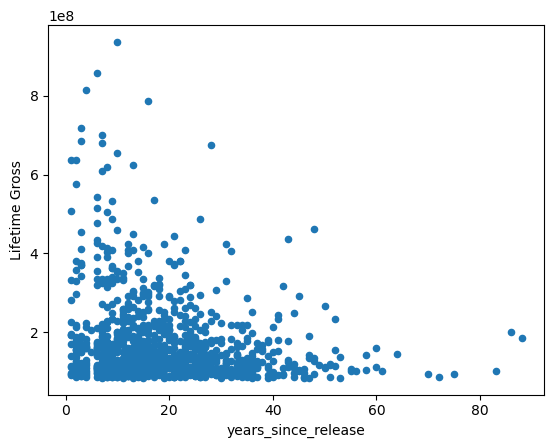

In [122]:
domestic_lifetime_gross_df.plot(x='years_since_release', y='Lifetime Gross', kind='scatter')

In [123]:
domestic_lifetime_gross_df['annualized_lifetime_gross'] = domestic_lifetime_gross_df['Lifetime Gross'] / domestic_lifetime_gross_df['years_since_release']
domestic_lifetime_gross_df['annualized_lifetime_gross']

0      9.366622e+07
1      1.430622e+08
2      2.037167e+08
3      4.907635e+07
4      2.395776e+08
           ...     
195    2.830647e+06
196    5.650194e+06
197    2.350403e+06
198    1.595531e+06
199    7.684130e+06
Name: annualized_lifetime_gross, Length: 1000, dtype: float64

In [124]:
domestic_lifetime_gross_df.sort_values('annualized_lifetime_gross', ascending=False)

,Rank,Title,Lifetime Gross,Year,years_since_release,annualized_lifetime_gross
10,11,Inside Out 2,637852840,2024,1,6.378528e+08
20,21,Deadpool & Wolverine,506937007,2024,1,5.069370e+08
81,82,Despicable Me 4,332583715,2024,1,3.325837e+08
11,12,Barbie,636238421,2023,2,3.181192e+08
15,16,The Super Mario Bros. Movie,574934330,2023,2,2.874672e+08
...,...,...,...,...,...,...
198,999,The Poseidon Adventure,84563118,1972,53,1.595531e+06
82,883,Lady and the Tramp,93602326,1955,70,1.337176e+06
91,892,Cinderella,93141149,1950,75,1.241882e+06
182,783,Bambi,102247150,1942,83,1.231893e+06


Let's make an important modification to the code that ChatGPT suggested to us:

In [125]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/"

# Sending a request to fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the table
table = soup.find('table')

# Extracting the table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extracting the rows
rows = []
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cells = []
    for cell in row.find_all('td'):

        # MODIFIED:
        if cell.find('a'):
            # Keeping the <a> tag as a string
            link = cell.find('a')
            cells.append(str(link))
        else:
            cells.append(cell.text.strip())
            
    if cells:  # Avoid empty rows
        rows.append(cells)

# Creating a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Displaying the DataFrame
df.head()


,Rank,Title,Lifetime Gross,Year
0,1,"<a class=""a-link-normal"" href=""/title/tt248849...","$936,662,225","<a class=""a-link-normal"" href=""/year/2015/?ref..."
1,2,"<a class=""a-link-normal"" href=""/title/tt415479...","$858,373,000","<a class=""a-link-normal"" href=""/year/2019/?ref..."
2,3,"<a class=""a-link-normal"" href=""/title/tt108726...","$814,866,759","<a class=""a-link-normal"" href=""/year/2021/?ref..."
3,4,"<a class=""a-link-normal"" href=""/title/tt049954...","$785,221,649","<a class=""a-link-normal"" href=""/year/2009/?ref..."
4,5,"<a class=""a-link-normal"" href=""/title/tt174596...","$718,732,821","<a class=""a-link-normal"" href=""/year/2022/?ref..."


Now, the code checks inside table cells (`<td>...</td>`) and if the cell contains an HTML link (`<a>`) it returns the actual HTML tag instead of the innermost text content.

In [127]:
# URL of the page
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/"

# Sending a request to fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the table
table = soup.find('table')

# Extracting the table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extracting the rows
rows = []
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cells = []
    for cell in row.find_all('td'):
        link = cell.find('a')
        if link:
            
            # MODIFIED:
            # Extracting only the href attribute
            cells.append(link.get('href'))
            
        else:
            cells.append(cell.text.strip())
    if cells:  # Avoid empty rows
        rows.append(cells)

# Creating a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Displaying the DataFrame
df.head()

,Rank,Title,Lifetime Gross,Year
0,1,/title/tt2488496/?ref_=bo_cso_table_1,"$936,662,225",/year/2015/?ref_=bo_cso_table_1
1,2,/title/tt4154796/?ref_=bo_cso_table_2,"$858,373,000",/year/2019/?ref_=bo_cso_table_2
2,3,/title/tt10872600/?ref_=bo_cso_table_3,"$814,866,759",/year/2021/?ref_=bo_cso_table_3
3,4,/title/tt0499549/?ref_=bo_cso_table_4,"$785,221,649",/year/2009/?ref_=bo_cso_table_4
4,5,/title/tt1745960/?ref_=bo_cso_table_5,"$718,732,821",/year/2022/?ref_=bo_cso_table_5


You can see that we have now extracted the contents of the `href` attribute within the `<a>` link tags, where they exist. Otherwise, the text is extracted.

The title identifiers seem to be valuable. If you click on "Star Wars: Episode VII - The Force Awakens" in the first row, it takes you to this page:

https://www.boxofficemojo.com/title/tt2488496/?ref_=bo_cso_table_1

And you can see that we have this data in the first row of our scraped table now:

In [128]:
df.loc[1, 'Title']

'/title/tt4154796/?ref_=bo_cso_table_2'

We could use this to construct a URL ourselves:


In [129]:
df.loc[1, 'Title'].split('/')

['', 'title', 'tt4154796', '?ref_=bo_cso_table_2']

In [130]:
df.loc[1, 'Title'].split('/')[2]

'tt4154796'

In [131]:
'https://www.boxofficemojo.com/title/' + df.loc[1, 'Title'].split('/')[2]

'https://www.boxofficemojo.com/title/tt4154796'

We'll have to change the code to run on the entire column, rather than a single cell:

In [132]:
df['Title'].str.split('/').str[2]

0       tt2488496
1       tt4154796
2      tt10872600
3       tt0499549
4       tt1745960
          ...    
195     tt0360717
196     tt0099653
197     tt0892769
198     tt0382625
199     tt0103639
Name: Title, Length: 200, dtype: object

In [133]:
'https://www.boxofficemojo.com/title/' + df['Title'].str.split('/').str[2]

0       https://www.boxofficemojo.com/title/tt2488496
1       https://www.boxofficemojo.com/title/tt4154796
2      https://www.boxofficemojo.com/title/tt10872600
3       https://www.boxofficemojo.com/title/tt0499549
4       https://www.boxofficemojo.com/title/tt1745960
                            ...                      
195     https://www.boxofficemojo.com/title/tt0360717
196     https://www.boxofficemojo.com/title/tt0099653
197     https://www.boxofficemojo.com/title/tt0892769
198     https://www.boxofficemojo.com/title/tt0382625
199     https://www.boxofficemojo.com/title/tt0103639
Name: Title, Length: 200, dtype: object

Let's combine this with the previous code block:

In [134]:
# URL of the page
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/"

# Sending a request to fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the table
table = soup.find('table')

# Extracting the table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extracting the rows
rows = []
for row in table.find_all('tr')[1:]:  # Skipping the header row
    cells = []
    for cell in row.find_all('td'):
        link = cell.find('a')
        if link:
            # Extracting only the href attribute
            cells.append(link.get('href'))
        else:
            cells.append(cell.text.strip())
    if cells:  # Avoid empty rows
        rows.append(cells)

# Creating a DataFrame
df = pd.DataFrame(rows, columns=headers)

# NEW STEPS: 
df['title_id'] = df['Title'].str.split('/').str[2]
df['title_page_url'] = 'https://www.boxofficemojo.com/title/' + df['title_id']

# Displaying the DataFrame
df.head()

,Rank,Title,Lifetime Gross,Year,title_id,title_page_url
0,1,/title/tt2488496/?ref_=bo_cso_table_1,"$936,662,225",/year/2015/?ref_=bo_cso_table_1,tt2488496,https://www.boxofficemojo.com/title/tt2488496
1,2,/title/tt4154796/?ref_=bo_cso_table_2,"$858,373,000",/year/2019/?ref_=bo_cso_table_2,tt4154796,https://www.boxofficemojo.com/title/tt4154796
2,3,/title/tt10872600/?ref_=bo_cso_table_3,"$814,866,759",/year/2021/?ref_=bo_cso_table_3,tt10872600,https://www.boxofficemojo.com/title/tt10872600
3,4,/title/tt0499549/?ref_=bo_cso_table_4,"$785,221,649",/year/2009/?ref_=bo_cso_table_4,tt0499549,https://www.boxofficemojo.com/title/tt0499549
4,5,/title/tt1745960/?ref_=bo_cso_table_5,"$718,732,821",/year/2022/?ref_=bo_cso_table_5,tt1745960,https://www.boxofficemojo.com/title/tt1745960


Really, all we care about is the `title_id` and `title_page_url`, so just return these. Plus wrap it all up into a function:

In [135]:
def scrape_title_ids(url):

    # Sending a request to fetch the content of the page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Finding the table
    table = soup.find('table')

    # Extracting the table headers
    headers = [header.text.strip() for header in table.find_all('th')]

    # Extracting the rows
    rows = []
    for row in table.find_all('tr')[1:]:  # Skipping the header row
        cells = []
        for cell in row.find_all('td'):
            link = cell.find('a')
            if link:
                # Extracting only the href attribute
                cells.append(link.get('href'))
            else:
                cells.append(cell.text.strip())
        if cells:  # Avoid empty rows
            rows.append(cells)

    # Creating a DataFrame
    df = pd.DataFrame(rows, columns=headers)

    # Extract title information...
    df['title_id'] = df['Title'].str.split('/').str[2]
    df['title_page_url'] = 'https://www.boxofficemojo.com/title/' + df['title_id']
    
    # ... and drop everything else:
    df = df[['title_id', 'title_page_url']]
    
    return df


Now let's run it on the entire 1000 movie list, spread over 5 pages:

In [136]:
domestic_title_identifiers_df = pd.concat([
    scrape_title_ids("https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset=" + str(offset)) 
    for offset in [0, 200, 400, 600, 800]
])

In [137]:
domestic_title_identifiers_df

,title_id,title_page_url
0,tt2488496,https://www.boxofficemojo.com/title/tt2488496
1,tt4154796,https://www.boxofficemojo.com/title/tt4154796
2,tt10872600,https://www.boxofficemojo.com/title/tt10872600
3,tt0499549,https://www.boxofficemojo.com/title/tt0499549
4,tt1745960,https://www.boxofficemojo.com/title/tt1745960
...,...,...
195,tt0112792,https://www.boxofficemojo.com/title/tt0112792
196,tt1536044,https://www.boxofficemojo.com/title/tt1536044
197,tt0098384,https://www.boxofficemojo.com/title/tt0098384
198,tt0069113,https://www.boxofficemojo.com/title/tt0069113


We have 1000 title IDs now, in the same order as the original data frame.

So what? Well, we can use identifiers such as these to extract more information, including linking to other pages.

Remember, we already have code to scrape the first table that appears on a webpage. Let's run it on the first link in our table (https://www.boxofficemojo.com/title/tt4154796):

In [138]:
scrape_boxoffice_mojo_table_text('https://www.boxofficemojo.com/title/tt4154796')

,Area,Release Date,Opening,Gross
0,Domestic,"Apr 26, 2019","$357,115,007","$858,373,000"


So it pulls out some useful information. But there's other information on different parts of that page.

Let's focus on the "MPAA", which in this case is "PG-13". It's not technically part of a table (although it looks like that to our eyes). Let's ask ChatGPT for help:

> Extract the value associated with the "MPAA" on the website https://www.boxofficemojo.com/title/tt4154796/

This is the code ChatGPT suggested:

In [139]:
import requests
from bs4 import BeautifulSoup

# URL of the page
url = "https://www.boxofficemojo.com/title/tt4154796/"

# Sending a request to fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding the MPAA rating
mpaa_label = soup.find(text="MPAA")
if mpaa_label:
    mpaa_value = mpaa_label.find_next('span').text.strip()
    print(f"MPAA Rating: {mpaa_value}")
else:
    print("MPAA Rating not found")


MPAA Rating: PG-13


/var/folders/rl/nrj4ktrj07v_0kf_cln4brw00000gn/T/ipykernel_35793/607728572.py:12: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  mpaa_label = soup.find(text="MPAA")


That's very useful! Let's simplify a little, and update the function call based on the warning above:

In [140]:
url = "https://www.boxofficemojo.com/title/tt4154796/"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

mpaa_label = soup.find(string="MPAA")
if mpaa_label:
    mpaa_value = mpaa_label.find_next('span').text.strip()
else:
    mpaa_value = None
    
mpaa_value

'PG-13'

Let's wrap this up into a function:

In [141]:
def get_mpaa_rating(title_page_url):
    response = requests.get(title_page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    mpaa_label = soup.find(string="MPAA")
    if mpaa_label:
        mpaa_value = mpaa_label.find_next('span').text.strip()
    else:
        mpaa_value = None
    return mpaa_value

In [142]:
get_mpaa_rating("https://www.boxofficemojo.com/title/tt4154796/")

'PG-13'

In [143]:
domestic_title_identifiers_df

,title_id,title_page_url
0,tt2488496,https://www.boxofficemojo.com/title/tt2488496
1,tt4154796,https://www.boxofficemojo.com/title/tt4154796
2,tt10872600,https://www.boxofficemojo.com/title/tt10872600
3,tt0499549,https://www.boxofficemojo.com/title/tt0499549
4,tt1745960,https://www.boxofficemojo.com/title/tt1745960
...,...,...
195,tt0112792,https://www.boxofficemojo.com/title/tt0112792
196,tt1536044,https://www.boxofficemojo.com/title/tt1536044
197,tt0098384,https://www.boxofficemojo.com/title/tt0098384
198,tt0069113,https://www.boxofficemojo.com/title/tt0069113


In [144]:
domestic_title_identifiers_df['title_page_url'].values[0:20]

array(['https://www.boxofficemojo.com/title/tt2488496',
       'https://www.boxofficemojo.com/title/tt4154796',
       'https://www.boxofficemojo.com/title/tt10872600',
       'https://www.boxofficemojo.com/title/tt0499549',
       'https://www.boxofficemojo.com/title/tt1745960',
       'https://www.boxofficemojo.com/title/tt1825683',
       'https://www.boxofficemojo.com/title/tt1630029',
       'https://www.boxofficemojo.com/title/tt4154756',
       'https://www.boxofficemojo.com/title/tt0120338',
       'https://www.boxofficemojo.com/title/tt0369610',
       'https://www.boxofficemojo.com/title/tt22022452',
       'https://www.boxofficemojo.com/title/tt1517268',
       'https://www.boxofficemojo.com/title/tt0848228',
       'https://www.boxofficemojo.com/title/tt2527336',
       'https://www.boxofficemojo.com/title/tt3606756',
       'https://www.boxofficemojo.com/title/tt6718170',
       'https://www.boxofficemojo.com/title/tt6105098',
       'https://www.boxofficemojo.com/title/tt

In [145]:
top20_mpaa_ratings = [ get_mpaa_rating(title_page_url) for title_page_url in domestic_title_identifiers_df['title_page_url'].values[0:20] ]
top20_mpaa_ratings


['PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG',
 'PG-13',
 'PG-13',
 'PG-13',
 'PG',
 'PG',
 'PG',
 'PG-13',
 'PG-13',
 'PG-13']

In [146]:
top20_domestic_lifetime_gross_df = domestic_lifetime_gross_df.head(20)
top20_domestic_lifetime_gross_df['mpaa_rating'] = top20_mpaa_ratings
top20_domestic_lifetime_gross_df

/var/folders/rl/nrj4ktrj07v_0kf_cln4brw00000gn/T/ipykernel_35793/820013363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20_domestic_lifetime_gross_df['mpaa_rating'] = top20_mpaa_ratings


,Rank,Title,Lifetime Gross,Year,years_since_release,annualized_lifetime_gross,mpaa_rating
0,1,Star Wars: Episode VII - The Force Awakens,936662225,2015,10,9.366622e+07,PG-13
1,2,Avengers: Endgame,858373000,2019,6,1.430622e+08,PG-13
2,3,Spider-Man: No Way Home,814866759,2021,4,2.037167e+08,PG-13
3,4,Avatar,785221649,2009,16,4.907635e+07,PG-13
4,5,Top Gun: Maverick,718732821,2022,3,2.395776e+08,PG-13
5,6,Black Panther,700426566,2018,7,1.000609e+08,PG-13
6,7,Avatar: The Way of Water,684075767,2022,3,2.280253e+08,PG-13
7,8,Avengers: Infinity War,678815482,2018,7,9.697364e+07,PG-13
8,9,Titanic,674292608,1997,28,2.408188e+07,PG-13
9,10,Jurassic World,653406625,2015,10,6.534066e+07,PG-13


## Quiz, for later

* Repeat what I have done for another characteristic of each movie, such as the `Budget` characteristic.
* Modify your code (and mine) to extract the MPAA rating and the Budget at the same time, i.e. from the same `soup` variable. This avoids having to download and parse each title page once per attribute. It's best to return them as a dataframe.
* If you have time, run this for every one of the 1000 movies in the original `domestic_lifetime_gross_df` dataframe. 
* Combine all these 1000 results into a single dataframe.
* Finally, combine your 1000-row dataframe with the original 1000-row `domestic_lifetime_gross_df` dataframe. 



In [ ]:
# TODO